In [1]:
import urllib.request
import os
import shutil
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
import random
from sklearn.model_selection import train_test_split

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, Binarizer
from sklearn.impute import SimpleImputer
from sklearn.datasets import load_breast_cancer
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score

from imgaug import augmenters as iaa

## Zapoznanie się z zestawami danych


### MNIST

http://yann.lecun.com/exdb/mnist/


MNIST (Modified National Institute of Standards and Technology database) - duży zbiór ręcznie zapisanych cyfr. Zawiera znormalizowane obrazki (28x28 px, anti-alliasing). 
Posiada 60'000 obrazów treningowych i 10'000 testowych.


Musimy zacząć od pobrania i zdekowania danych. Można zrobic to np. na piechotę:

In [2]:
mnist_prefix = "./mnist"
if os.path.isdir(mnist_prefix):
    shutil.rmtree(mnist_prefix)
os.mkdir(mnist_prefix)
base_url = "http://yann.lecun.com/exdb/mnist/"
datasets = ["train-labels-idx1-ubyte.gz", "train-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz", "t10k-images-idx3-ubyte.gz"]

In [3]:
def fetch_gz(base_url, name):
    path = "{}/{}".format(mnist_prefix, name)
    urllib.request.urlretrieve("{}{}".format(base_url, name), path)
    data_file = gzip.open(path, "rb")
    data = data_file.read()
    data_file.close()
    return data

In [4]:
def decode_mnist(data):
    magic_number = int.from_bytes(data[0:4], byteorder='big')
    if magic_number == 2051:
        number_of_images = int.from_bytes(data[4:8], byteorder='big')
        rows = int.from_bytes(data[8:12], byteorder='big')
        columns = int.from_bytes(data[12:16], byteorder='big')
        print("File contains {} images {}x{}".format(number_of_images, rows, columns))
        pixels = [int(b) for b in data[16:]]
        return np.array(pixels).reshape((number_of_images, rows, columns))
    elif magic_number == 2049:
        number_of_labels = int.from_bytes(data[4:8], byteorder='big')
        print("File contain {} labels".format(number_of_labels))
        return [int(b) for b in data[8:]]

In [5]:
(train_labels, train_images, test_labels, test_images) = [decode_mnist(fetch_gz(base_url, ds)) for ds in datasets]

File contain 60000 labels
File contains 60000 images 28x28
File contain 10000 labels
File contains 10000 images 28x28


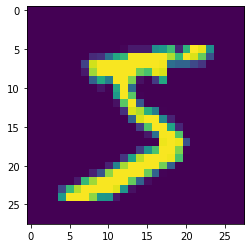

In [6]:
plt.imshow(train_images[0])

In [7]:
train_labels[0]

5

Lub w bardziej cywilizowany sposób używając gotowych funkcji bibliotek i pobierając dane np. z openml (https://www.openml.org/search?type=data):

In [8]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

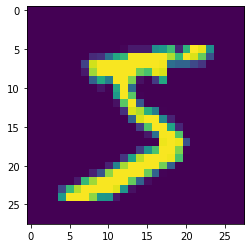

In [9]:
plt.imshow(np.array(mnist.data[0]).reshape(28,28))

### Fashion-MNIST

Fashion-MNIST

Zbiór analogiczny do MNIST, zawiera obrazy przedstawiające elementy odzieży. 70'000 obrazów 28x28 px w skali szarości. Wskazywany jako następca MNIST ( MNIST jest uznawany za zbyt prosty, zbyt często używany, FMNIST lepiej oddaje współczesne problemy Computer Vision).


https://github.com/zalandoresearch/fashion-mnist

In [10]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Description  
0  T-shirt/top  
1  Trouser  
2  Pullover  
3  Dress  
4  

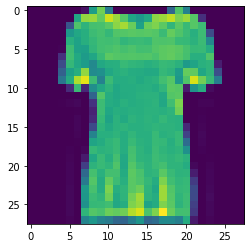

In [11]:
print(fmnist.DESCR)

plt.imshow(np.array(fmnist.data[10]).reshape(28,28))
print('Category:', fmnist.target[10])

### CIFAR-10

Zbiór małych, kolorowych (RGB) obrazków 32x32. Obrazki są podzielone na 10 klas. Jest podzielony na 50000 elemntowy zbiór treningowy i 10000 zbiór testowy.

https://www.cs.toronto.edu/~kriz/cifar.html

In [12]:
#cifar10 = fetch_openml("CIFAR_10")

In [13]:
#print(cifar10.DESCR)

#single_img_reshaped = np.transpose(np.array(cifar10.data[623]).reshape(3,32,32).astype(int) , (1,2,0))
#plt.imshow(single_img_reshaped)

### SmallNorb

Zbiór obrazków służący do eksperymentów z rozpoznawaniem obiektów 3D. Zawiera 50 zabawek podzielonych na 5 kategorii

https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/

### TNG

The Next Generation. Zbiór danych z filmu Star Trek zawierający opisy scen z filmu.

https://github.com/RMHogervorst/TNG

In [14]:
TNG_prefix = './TNG'
TNG_name = 'ng20.csv'
TNG_path = '{}/{}'.format(TNG_prefix, TNG_name)

In [15]:
TNG = pd.read_csv(TNG_path, header=None)
TNG

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,12.235819,0.000000,0.0,26.554754,0.000000,0.000000,0.000000,0.0,3.0
1,0.000000,6.462056,5.265274,0.0,4.559959,0.000000,0.0,0.000000,2.119816,0.000000,...,7.248282,0.000000,2.529904,0.0,0.000000,4.073248,0.000000,1.084394,0.0,9.0
2,17.636751,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,2.0
3,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.039917,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.700282,0.000000,0.0,16.0
4,0.000000,0.000000,0.000000,0.0,2.074241,0.000000,0.0,0.648221,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.667010,0.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,0.000000,0.000000,0.248722,0.0,0.000000,3.898138,0.0,2.554687,0.000000,4.410306,...,0.000000,0.000000,0.000000,0.0,0.000000,0.785907,0.000000,0.000000,0.0,12.0
5650,0.000000,0.000000,0.000000,0.0,0.320675,0.000000,0.0,3.230011,0.000000,0.000000,...,0.000000,1.078652,0.000000,0.0,2.671853,0.000000,0.113560,0.000000,0.0,8.0
5651,0.000000,0.000000,0.000000,0.0,0.000000,0.860070,0.0,1.224586,0.000000,0.457255,...,0.000000,0.000000,0.000000,0.0,0.303810,0.000000,0.000000,0.000000,0.0,4.0
5652,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,8.226898,0.000000,0.0,5.754258,0.000000,0.000000,0.000000,0.0,6.0


### Communities and Crime Unnormalized 

Zbiór danych UCI "Communities and Crime Unnormalized", dotyczących przestępczości w USA _(M=2215, N=143)_ .

https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
https://www.kaggle.com/kkanda/communities%20and%20crime%20unnormalized%20data%20set/data

In [16]:
cc_prefix = "./communities_and_crimes"
cc_name = "crimedata.csv"
cc_path = "{}/{}".format(cc_prefix, cc_name)

In [17]:
crimes = pd.read_csv(cc_path)

## Procedury normalizujące dane i wybierające dane ze zbioru danych

### Wybieranie danych

Najprostszy sposób na zmniejszenie rozmiaru datasetu - wzięcie n początkowych elementów:

In [18]:
fmnist_zipped = zip(fmnist.data, fmnist.target)
fmnist_reduced_list = list(fmnist_zipped)[:1000]

fmnist_reduced_data, fmnist_reduced_target = zip(*(fmnist_reduced_list))
print((list(fmnist_reduced_target)[0:10]))


['9', '0', '0', '3', '0', '2', '7', '2', '5', '5']


Wzięcie _n_ losowych elementów z datasetu (bez modyfikacji kolejności w źródłowym datasecie):

In [19]:
fmnist_random_sample = random.sample(fmnist_reduced_list, 100)
fmnist_reduced_data, fmnist_reduced_target = zip(*(fmnist_random_sample))
print((list(fmnist_reduced_target)[0:10]))

['4', '1', '3', '4', '5', '5', '1', '8', '4', '6']


Podział danych na zbiór testowy oraz treningowy przy pomocy _sklearn_ :

In [20]:
X = fmnist.data
y = fmnist.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train: ', len(X_train), ' y_train: ', len(y_train))
print('X_test: ', len(X_test), ' y_test: ', len(y_test))

X_train:  56000  y_train:  56000
X_test:  14000  y_test:  14000


### Normalizacja danych

In [21]:
cc_df = crimes.set_index(['communityname', 'state', 'countyCode', 'communityCode']).replace('?', np.NaN)
cc_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,...,14,114.85,138,1132.08,16,131.26,2,16.41,41.02,1394.59
Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,...,57,242.37,376,1598.78,26,110.55,1,4.25,127.56,1955.95
Tigardcity,OR,?,?,1,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,...,274,758.14,1797,4972.19,136,376.3,22,60.87,218.59,6167.51
Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,...,225,1301.78,716,4142.56,47,271.93,NaN,NaN,306.64,NaN
Bemidjicity,MN,7,5068,1,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,...,91,728.93,1060,8490.87,91,728.93,5,40.05,NaN,9988.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,10,56216,3.07,6.87,61.68,15.23,29.86,15.46,30.16,14.34,...,1376,2268.72,2563,4225.82,489,806.25,34,56.06,545.75,7356.84
Pinevillecity,LA,?,?,10,12251,2.68,21.18,76.65,1.52,1.29,17.36,31.23,16.97,...,104,860.43,574,4748.9,24,198.56,2,16.55,124.1,5824.44
Yucaipacity,CA,?,?,10,32824,2.46,0.52,92.62,0.98,11.00,11.81,20.96,9.53,...,628,1709.26,895,2435.97,179,487.19,8,21.77,353.83,4654.2


#### Uzupełnianie brakujących danych

In [22]:
imp=SimpleImputer(missing_values=np.NaN, strategy='mean')

cc_df_filled = pd.DataFrame(imp.fit_transform(cc_df.values), index=cc_df.index, columns=cc_df.columns)
cc_df_filled

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,1.0,11980.0,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.000000,16.410000,41.020000,1394.590000
Marpletownship,PA,45,47616,1.0,23123.0,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.000000,4.250000,127.560000,1955.950000
Tigardcity,OR,?,?,1.0,29344.0,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.000000,60.870000,218.590000,6167.510000
Gloversvillecity,NY,35,29443,1.0,16656.0,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,...,225.0,1301.78,716.0,4142.56,47.0,271.93,30.907721,32.153682,306.640000,4908.241804
Bemidjicity,MN,7,5068,1.0,11245.0,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.000000,40.050000,589.078922,9988.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,10.0,56216.0,3.07,6.87,61.68,15.23,29.86,15.46,30.16,14.34,...,1376.0,2268.72,2563.0,4225.82,489.0,806.25,34.000000,56.060000,545.750000,7356.840000
Pinevillecity,LA,?,?,10.0,12251.0,2.68,21.18,76.65,1.52,1.29,17.36,31.23,16.97,...,104.0,860.43,574.0,4748.90,24.0,198.56,2.000000,16.550000,124.100000,5824.440000
Yucaipacity,CA,?,?,10.0,32824.0,2.46,0.52,92.62,0.98,11.00,11.81,20.96,9.53,...,628.0,1709.26,895.0,2435.97,179.0,487.19,8.000000,21.770000,353.830000,4654.200000


#### Skalowanie Min-Max

Dla każdej klasy znajdowna jest wartość $x_{max}$ oraz $x_{min}$, a następnie dla rekordu $i$ obliczana jest przeskalowana wartość $x_i$ atrybutu danej klasy:

$x_{scaled_{i}} = \frac{x_i - x_{min}}{x_{max} - x_{min}}$

In [23]:
minmax = MinMaxScaler(feature_range=(0,1))
minmax_df = minmax.fit_transform(cc_df_filled)
df_scaled = pd.DataFrame(minmax_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
df_scaled

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,0.0,0.000270,0.407609,0.014172,0.919030,0.112659,0.018493,0.158370,0.197284,0.106646,...,0.000121,0.008254,0.000544,0.040810,0.000133,0.025133,0.000391,0.037606,0.008411,0.047321
Marpletownship,PA,45,47616,0.0,0.001794,0.331522,0.008276,0.958123,0.059377,0.007670,0.129065,0.194994,0.099017,...,0.000554,0.019003,0.001557,0.058876,0.000222,0.020959,0.000195,0.009739,0.026155,0.068110
Tigardcity,OR,?,?,0.0,0.002645,0.225543,0.007655,0.945333,0.059203,0.023432,0.136090,0.269917,0.108003,...,0.002742,0.062476,0.007600,0.189463,0.001200,0.074516,0.004298,0.139492,0.044820,0.224076
Gloversvillecity,NY,35,29443,0.0,0.000910,0.217391,0.017586,0.976483,0.008184,0.006094,0.159976,0.258793,0.128009,...,0.002248,0.108298,0.003003,0.157347,0.000409,0.053482,0.006038,0.073684,0.062874,0.177442
Bemidjicity,MN,7,5068,0.0,0.000170,0.315217,0.005483,0.892006,0.019850,0.004203,0.399037,0.509570,0.407765,...,0.000897,0.060014,0.004466,0.325673,0.000800,0.145581,0.000977,0.091780,0.120786,0.365589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,1.0,0.006319,0.399457,0.071067,0.608561,0.264670,0.312493,0.218386,0.339931,0.164463,...,0.013850,0.189799,0.010858,0.160570,0.004339,0.161164,0.006642,0.128469,0.111901,0.268121
Pinevillecity,LA,?,?,1.0,0.000307,0.293478,0.219096,0.762971,0.025945,0.012294,0.256523,0.357435,0.209054,...,0.001028,0.071098,0.002399,0.180819,0.000205,0.038696,0.000391,0.037927,0.025446,0.211371
Yucaipacity,CA,?,?,1.0,0.003121,0.233696,0.005379,0.927695,0.016542,0.114322,0.145122,0.189432,0.082909,...,0.006310,0.142644,0.003764,0.091284,0.001583,0.096863,0.001563,0.049889,0.072550,0.168034


#### Standaryzacja

Polega na przeskalowaniu każdej klasy przy pomocy wartości średniej i odchylenia standardowego danej klasy:

$x_{std_{i}} = \frac{x_i - \bar{x}}{\sigma}$


In [24]:
standscaler = StandardScaler()
standscaler_df = standscaler.fit_transform(cc_df_filled)
st_df = pd.DataFrame(standscaler_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
st_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,-1.564737,-0.201091,1.175511,-0.559192,0.475175,0.856235,-0.416149,-0.437364,-1.004000,-0.510125,...,-0.240355,-1.204435,-0.263327,-1.179670,-0.153812,-0.679688,-0.163927,-4.098068e-01,-9.398046e-01,-1.311840
Marpletownship,PA,45,47616,-1.564737,-0.146622,0.337299,-0.599209,0.706056,0.172105,-0.486762,-0.760544,-1.026653,-0.585510,...,-0.226523,-1.037232,-0.231985,-0.933986,-0.150740,-0.720762,-0.169598,-7.263307e-01,-7.914068e-01,-1.102253
Tigardcity,OR,?,?,-1.564737,-0.116212,-0.830211,-0.603422,0.630518,0.169869,-0.383928,-0.683070,-0.285567,-0.496724,...,-0.156724,-0.360958,-0.044857,0.841868,-0.116948,-0.193700,-0.050513,7.474836e-01,-6.353097e-01,0.470154
Gloversvillecity,NY,35,29443,-1.564737,-0.178234,-0.920020,-0.536025,0.814491,-0.485197,-0.497046,-0.419656,-0.395597,-0.299049,...,-0.172485,0.351858,-0.187211,0.405128,-0.144289,-0.400697,0.000000,1.849537e-16,-4.843227e-01,0.000000
Bemidjicity,MN,7,5068,-1.564737,-0.204684,0.157682,-0.618165,0.315569,-0.335403,-0.509386,2.216698,2.084936,2.465049,...,-0.215587,-0.399258,-0.141911,2.694196,-0.130772,0.505671,-0.146915,2.055406e-01,-1.949488e-16,1.896848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,1.568667,0.015144,1.085703,-0.173063,-1.358472,2.808018,1.502058,0.224491,0.406976,0.061121,...,0.197743,1.619702,0.056016,0.448958,-0.008507,0.659020,0.017535,6.222797e-01,-7.429989e-02,0.914196
Pinevillecity,LA,?,?,1.568667,-0.199766,-0.081807,0.831575,-0.446522,-0.257153,-0.456597,0.645068,0.580112,0.501702,...,-0.211406,-0.226836,-0.205911,0.724322,-0.151355,-0.546212,-0.163927,-4.061627e-01,-7.973400e-01,0.342067
Yucaipacity,CA,?,?,1.568667,-0.099201,-0.740403,-0.618867,0.526347,-0.377882,0.209085,-0.583459,-1.081668,-0.744655,...,-0.042857,0.886143,-0.163639,-0.493267,-0.103739,0.026228,-0.129903,-2.702864e-01,-4.034019e-01,-0.094848


#### Normalizacja

Polega na sprowadzeniu każdego wektora do długości 1 w normie L1 lub L2 (przydatna, jeśli ważny jest kierunek wektora).


In [25]:
norm = Normalizer(norm='l2')
norm_df = norm.fit_transform(cc_df_filled)
norm_df = pd.DataFrame(norm_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
norm_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,3.107376e-08,0.000372,9.632866e-08,4.257105e-08,0.000003,2.019795e-07,5.841867e-08,3.874898e-07,6.662214e-07,3.396362e-07,...,4.350327e-07,0.000004,0.000004,0.000035,4.971802e-07,0.000004,6.214752e-08,5.099204e-07,0.000001,0.000043
Marpletownship,PA,45,47616,3.107605e-08,0.000719,8.763447e-08,2.486084e-08,0.000003,1.069016e-07,2.641464e-08,3.421473e-07,6.619199e-07,3.256770e-07,...,1.771335e-06,0.000008,0.000012,0.000050,8.079773e-07,0.000003,3.107605e-08,1.320732e-07,0.000004,0.000061
Tigardcity,OR,?,?,3.107700e-08,0.000912,7.551712e-08,2.299698e-08,0.000003,1.065941e-07,7.303096e-08,3.530348e-07,8.042729e-07,3.421578e-07,...,8.515099e-06,0.000024,0.000056,0.000155,4.226473e-06,0.000012,6.836941e-07,1.891657e-06,0.000007,0.000192
Gloversvillecity,NY,35,29443,3.107735e-08,0.000518,7.458565e-08,5.283150e-08,0.000003,1.553868e-08,2.175415e-08,3.900208e-07,7.831493e-07,3.788329e-07,...,6.992404e-06,0.000040,0.000022,0.000129,1.460636e-06,0.000008,9.605302e-07,9.992513e-07,0.000010,0.000153
Bemidjicity,MN,7,5068,3.107739e-08,0.000349,8.577359e-08,1.647102e-08,0.000003,3.636055e-08,1.616024e-08,7.601529e-07,1.259567e-06,8.916103e-07,...,2.828042e-06,0.000023,0.000033,0.000264,2.828042e-06,0.000023,1.553869e-07,1.244649e-06,0.000018,0.000310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,3.107694e-07,0.001747,9.540621e-08,2.134986e-07,0.000002,4.733018e-07,9.279575e-07,4.804495e-07,9.372806e-07,4.456433e-07,...,4.276187e-05,0.000071,0.000080,0.000131,1.519662e-05,0.000025,1.056616e-06,1.742173e-06,0.000017,0.000229
Pinevillecity,LA,?,?,3.107733e-07,0.000381,8.328724e-08,6.582178e-07,0.000002,4.723754e-08,4.008975e-08,5.395024e-07,9.705450e-07,5.273823e-07,...,3.232042e-06,0.000027,0.000018,0.000148,7.458559e-07,0.000006,6.215466e-08,5.143298e-07,0.000004,0.000181
Yucaipacity,CA,?,?,3.107660e-07,0.001020,7.644843e-08,1.615983e-08,0.000003,3.045507e-08,3.418426e-07,3.670146e-07,6.513655e-07,2.961600e-07,...,1.951610e-05,0.000053,0.000028,0.000076,5.562711e-06,0.000015,2.486128e-07,6.765375e-07,0.000011,0.000145


In [26]:
norm = Normalizer(norm='l1')
norm_df = norm.fit_transform(cc_df_filled)
norm_df = pd.DataFrame(norm_df, columns=cc_df_filled.columns, index=cc_df_filled.index)
norm_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,2.945559e-08,0.000353,9.131234e-08,4.035416e-08,0.000003,1.914614e-07,5.537651e-08,3.673112e-07,6.315279e-07,3.219496e-07,...,4.123783e-07,0.000003,0.000004,0.000033,4.712895e-07,0.000004,5.891119e-08,4.833663e-07,0.000001,0.000041
Marpletownship,PA,45,47616,2.982274e-08,0.000690,8.410014e-08,2.385819e-08,0.000003,1.025902e-07,2.534933e-08,3.283484e-07,6.352244e-07,3.125424e-07,...,1.699896e-06,0.000007,0.000011,0.000048,7.753913e-07,0.000003,2.982274e-08,1.267467e-07,0.000004,0.000058
Tigardcity,OR,?,?,3.004280e-08,0.000882,7.300401e-08,2.223167e-08,0.000003,1.030468e-07,7.060058e-08,3.412862e-07,7.775077e-07,3.307712e-07,...,8.231727e-06,0.000023,0.000054,0.000149,4.085821e-06,0.000011,6.609416e-07,1.828705e-06,0.000007,0.000185
Gloversvillecity,NY,35,29443,3.028114e-08,0.000504,7.267473e-08,5.147793e-08,0.000003,1.514057e-08,2.119680e-08,3.800283e-07,7.630846e-07,3.691271e-07,...,6.813256e-06,0.000039,0.000022,0.000125,1.423213e-06,0.000008,9.359209e-07,9.736500e-07,0.000009,0.000149
Bemidjicity,MN,7,5068,3.031866e-08,0.000341,8.367951e-08,1.606889e-08,0.000003,3.547284e-08,1.576570e-08,7.415945e-07,1.228815e-06,8.698424e-07,...,2.758998e-06,0.000022,0.000032,0.000257,2.758998e-06,0.000022,1.515933e-07,1.214262e-06,0.000018,0.000303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,3.001876e-07,0.001688,9.215761e-08,2.062289e-07,0.000002,4.571858e-07,8.963603e-07,4.640901e-07,9.053659e-07,4.304691e-07,...,4.130582e-05,0.000068,0.000077,0.000127,1.467918e-05,0.000024,1.020638e-06,1.682852e-06,0.000016,0.000221
Pinevillecity,LA,?,?,3.025554e-07,0.000371,8.108485e-08,6.408123e-07,0.000002,4.598842e-08,3.902965e-08,5.252362e-07,9.448805e-07,5.134365e-07,...,3.146576e-06,0.000026,0.000017,0.000144,7.261329e-07,0.000006,6.051108e-08,5.007292e-07,0.000004,0.000176
Yucaipacity,CA,?,?,2.993907e-07,0.000983,7.365012e-08,1.556832e-08,0.000003,2.934029e-08,3.293298e-07,3.535805e-07,6.275230e-07,2.853194e-07,...,1.880174e-05,0.000051,0.000027,0.000073,5.359094e-06,0.000015,2.395126e-07,6.517736e-07,0.000011,0.000139


#### Binaryzacja

W zależności od wartości progowej, jako wartość cechy przypisuje 0 lub 1.


In [27]:
binarizer = Binarizer(threshold=10.0).fit_transform(cc_df_filled)
binary_df = pd.DataFrame(binarizer, columns=cc_df_filled.columns, index=cc_df_filled.index)
binary_df

,,,,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,state,countyCode,communityCode,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,NJ,39,5320,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Marpletownship,PA,45,47616,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Tigardcity,OR,?,?,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Gloversvillecity,NY,35,29443,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bemidjicity,MN,7,5068,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mercedcity,CA,?,?,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Pinevillecity,LA,?,?,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
Yucaipacity,CA,?,?,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


## Algorytm k-NN

Czasem chcemy móc etykietować pewien zaobserwowany wzorzec x (np. podział obszar w przestrzeni) nie posiadając wiedzy o jego rozkładzie statystycznym, ale mając pewne punkty pomiarowe z właściwościami, na których możemy się oprzeć przy klasyfikowaniu całej przestrzeni. 

Algorytm kNN (k najbliższych sąsiadów) oblicza dystans każdy-do-każdego takich punktów pomiarowych w przestrzeni euklidesowej, po czym wybiera k najbliższych obiektów do rozważanego. Te k najbliższych sąsiadów uznaje się, że są najbardziej zbliżone cechami. Dla każdego punktu w przestrzeni bierzemy k najbliższych sąsiadów i przypisujemy go do klasy z etykietą, którą ma większość z tych k najbliższych punktów danych (tzw. majority voting).
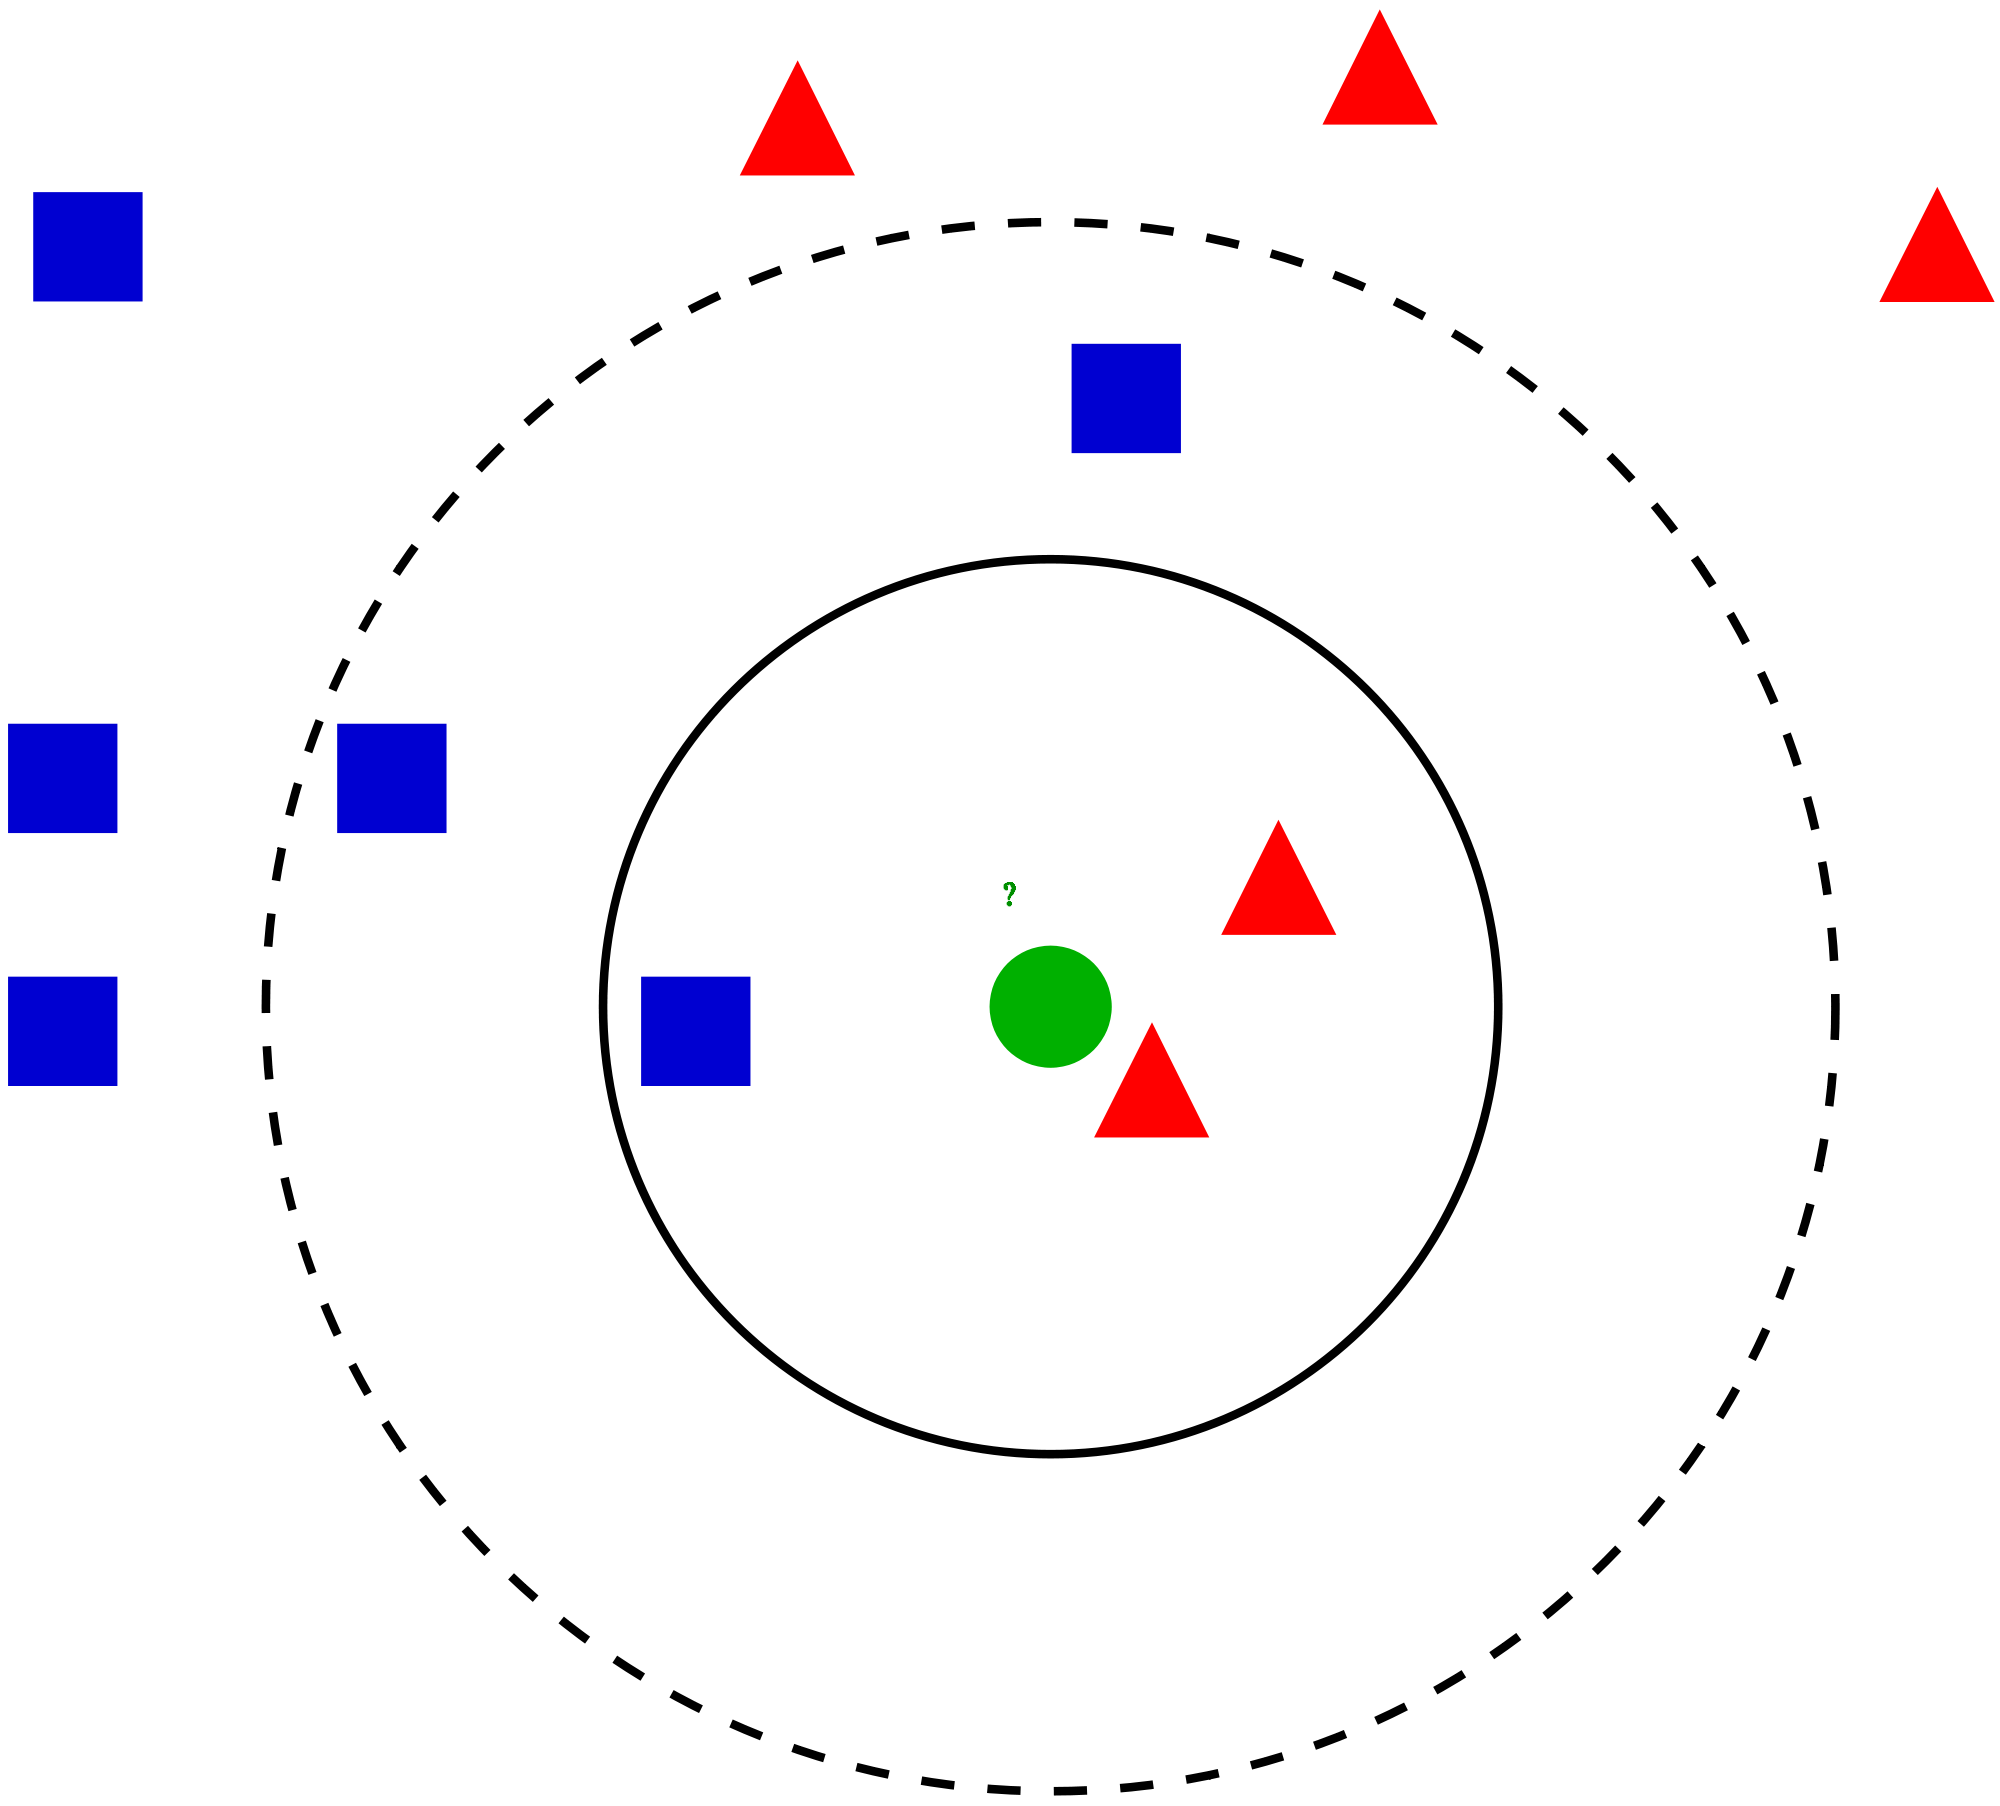
Uproszczoną wizualizacją problemu jest powyższy obrazek: do którego zbioru, czerwonego czy niebieskiego, powinien należeć rozważany zielony punkt? 

### Zasada NN

Zasada NN używa tylko najbliższego sąsiada jako klasyfikator, ignorując pozostałe wyetykietowane punkty pomiarowe. 

### Zasada kNN
Liczba k powinna być:

- wystarczająco duża by zminimalizować prawdopodobieństwo złego zaklasyfikowania x. 
- wystarczająco mała (w stosunku do ilości próbek) tak, by punkty wystarczająco bliskie do x by dać dokładne przybliżenie prawdziwej klasy x.

#### Przykładowe wyszukanie najbliższego sąsiada dla punktów pomiarowych

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
print(distances)
print(indices)

[[0.         1.        ]
 [0.         1.        ]
 [0.         1.41421356]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.41421356]]
[[0 1]
 [1 0]
 [2 1]
 [3 4]
 [4 3]
 [5 4]]


#### Przykładowe wykorzystanie

Poeksperymentuj z k i zobacz, jak zmienia się podział danego obszaru na klasy.

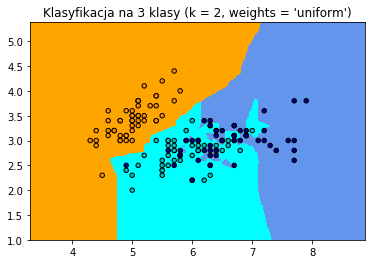

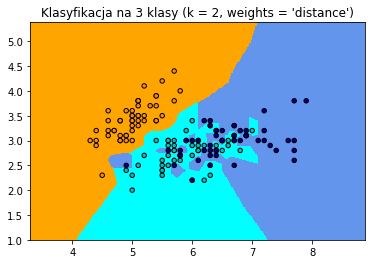

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

k = 2

# importujemy przykładowy zbiór danych
iris = datasets.load_iris()

# bierzemy tylko 2 pierwsze wymiary z danych (żeby łatwo wizualizować)
X = iris.data[:, :2]
y = iris.target

h = .02  # jak duży rozmiar obszarów rozważanych

# mapy kolorków do wyświetlania
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

for weights in ['uniform', 'distance']:
    # Używamy klasyfikatora i fitujemy dane
    clf = neighbors.KNeighborsClassifier(k, weights=weights)
    clf.fit(X, y)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Rezultat dodajemy do mapy
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Rysujemy też punkty danych
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Klasyfikacja na 3 klasy (k = %i, weights = '%s')"
              % (k, weights))

plt.show()

### FAISS

Biblioteka do szybkiego liczenia, wykorzystująca CUDA, znacznie przyśpiesza obliczenia dzięki użyciu GPU.

https://github.com/facebookresearch/faiss

#### Porównanie ilości przetwarzanych danych na sekundę
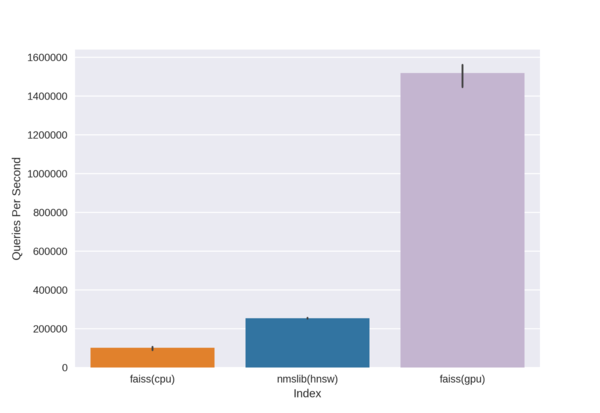

#### Dla odważnych (z Nvidią i CUDA) Instalacja i wykorzystanie w praktyce

https://github.com/facebookresearch/faiss/blob/master/INSTALL.md

Kod jest dostępny w pliku faiss.py, odpalić to można za pomocą:



In [30]:
!python3 faiss.py

Traceback (most recent call last):
  File "faiss.py", line 1, in <module>
    import faiss
  File "/Users/oscarteeninga/Library/Mobile Documents/com~apple~CloudDocs/Informatyka IET/Semestr 6/Machine Learning/Lab1/AGH-ML-Tutorial1-exercises/faiss.py", line 10, in <module>
    quantiser = faiss.IndexFlatL2(dimension)
AttributeError: module 'faiss' has no attribute 'IndexFlatL2'


## Miary jakości klasyfikatora


### Cross-validation

Walidacja krzyżowa to metoda statystyczna, polegająca na podziale próby statystycznej na podzbiory, a następnie przeprowadzaniu wszelkich analiz na niektórych z nich (zbiór uczący), podczas gdy pozostałe służą do potwierdzenia wiarygodności jej wyników (zbiór testowy, zbiór walidacyjny).

#### Wybrane strategie walidacji krzyżowej

* leave-one-out

Po kolei każdy sample wybierany jest jako zbiór testowy, a pozostałe sample to zbiór treningowy.
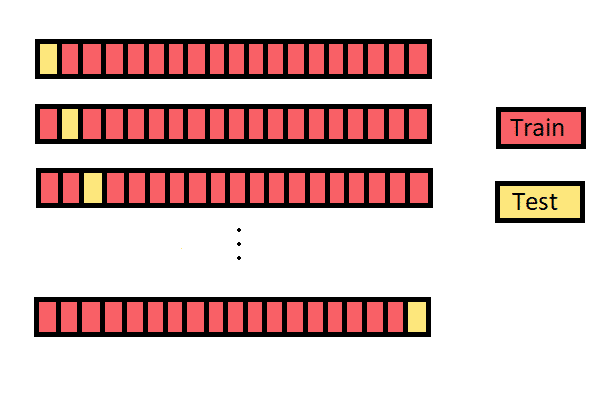

* leave-p-out

Po kolei wybierane są p-elementowe podzbiory jako zbiór testowy, a pozostałe elementy pozostają w zbiorze treningowym.
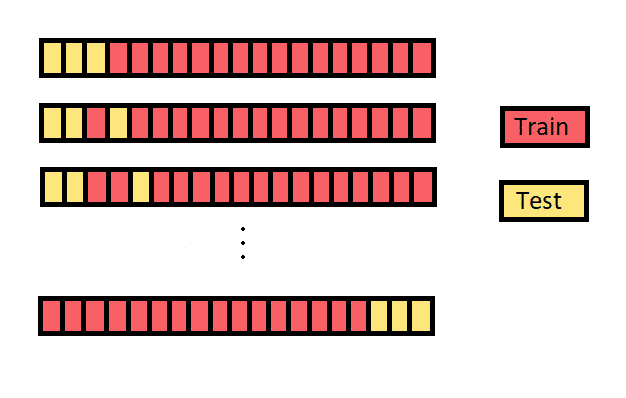

* holdout

Dane dzielone są na zbiór treningowy i testowy.
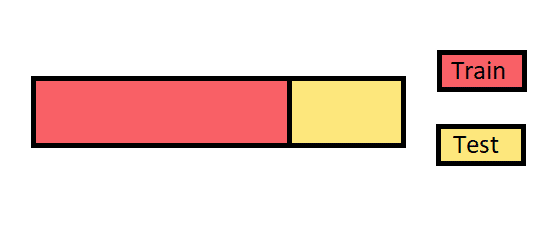

* k-fold

Zbiór dzielony jest na k-podzbiorów i po kolei przeprowadza się walidację dla każdego podzbioru jako zbioru testowego.
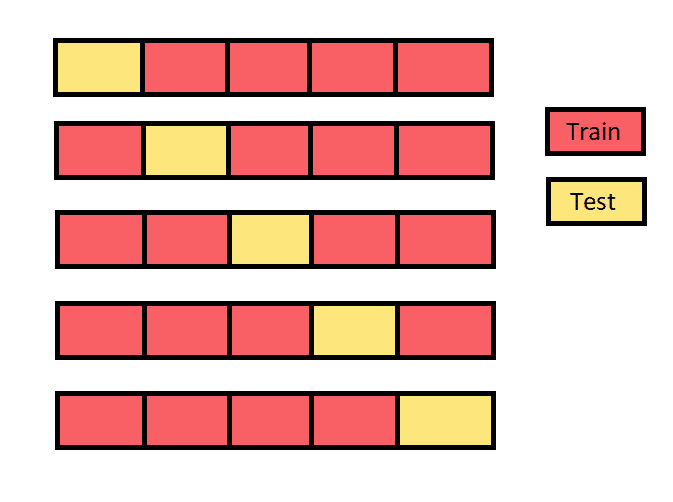

### Miary jakości klasyfikacji

Dataset wykorzystany w tym ćwiczeniu: Breast Cancer Wisconsin (Diagnostic) Data Set. Zawiera dane dotyczące raka piersi, z klasyfikacją na nowotwór łagodny i złośliwy.

In [31]:
cancer = load_breast_cancer()
#print(cancer.DESCR)

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state = 42)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Classification accuracy
Stosunek poprawnych klasyfikacji i wszystkich klasyfikacji. Bardzo prosta miara. Parametr _cv_ określa liczbę podzbiorów w walidacji krzyżowej.

In [32]:
scoring = 'accuracy'
results = cross_val_score(knn, X_train, y_train, cv=5, scoring=scoring)
print(results)
print("Accuracy: %.3f (%.3f)" % (np.mean(results), np.std(results)))

[0.93406593 0.9010989  0.95604396 0.9010989  0.92307692]
Accuracy: 0.923 (0.021)


#### Confusion matrix

Macierz obrazująca, jak liczbowo przedstawia się wynik klasyfikacji dla danego zbioru - jaki był stan faktyczny zbioru, a jak został on sklasyfikowany.

[[38  5]
 [ 0 71]]


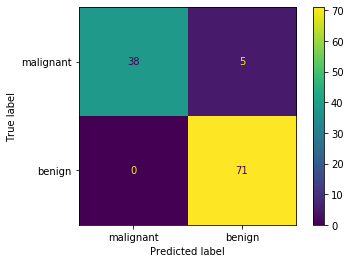

In [33]:
predicted = knn.predict(X_test)
matrix = confusion_matrix(y_test, predicted)
print(matrix)
disp = plot_confusion_matrix(knn, X_test, y_test, display_labels=cancer.target_names)
plt.show()

#### Classification report

Scikit zapewnia możliwość wygenerowania złożonego raportu dotyczącego jakości działania klasyfikatora. Dostępne są w nim między innymi takie metryki jak:

* precision

${PPV}=\frac{TP}{TP + FP}$

* recall 

${TPR}=\frac{TP}{TP + FN}$

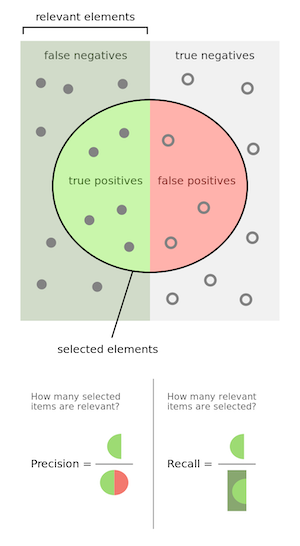

* f1-score

Średnia harmoniczna precision i recall dla każdej klasy.

* support

Liczba wystąpień danej klasy w zbiorze _y\_test_.

* accuracy

Stosunek poprawnych predykcji do wszystkich predykcji.

* macro average

Średnia arytmetyczna parametrów dla wszystkich klas.

* weighted average

Ważona średnia arytmetyczna (wagami są supporty) dla wszystkich klas.

In [34]:
predicted = knn.predict(X_test)
report = classification_report(y_test, predicted, target_names=cancer.target_names)
print(report)

              precision    recall  f1-score   support

   malignant       1.00      0.88      0.94        43
      benign       0.93      1.00      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



#### Area Under ROC Curve

Krzywa ROC (Receiver Operating Characteristic) jest graficzną reprezentacją efektywności modelu predykcyjnego poprzez wykreślenie charakterystyki jakościowej klasyfikatorów binarnych powstałych z modelu przy zastosowaniu wielu różnych punktów odcięcia.

W uproszczeniu, im większe pole pod wykresem tej krzywej, tym lepszy jest nasz model. Pole 1 odpowiada idealnemu modelowi, pole 0.5 odpowiada losowej klasyfikacji.

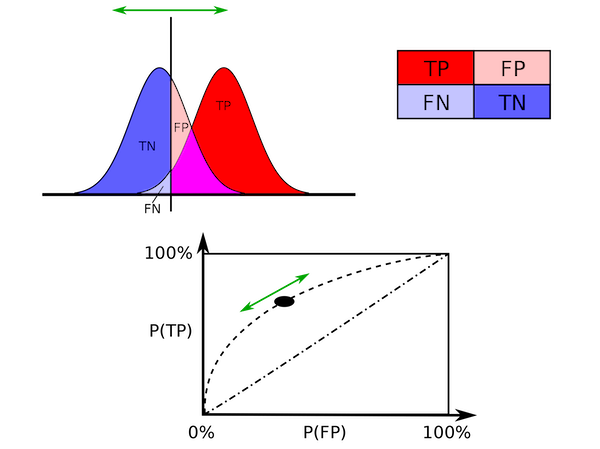
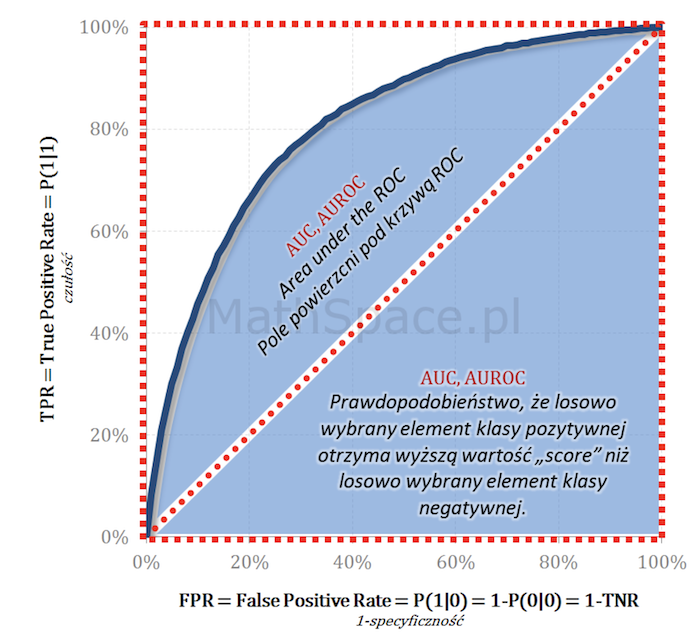

In [35]:
scoring = 'roc_auc'
results = cross_val_score(knn, X_train, y_train, cv=5, scoring=scoring)
print(results)
print("AUC: %.3f (%.3f)" % (np.mean(results), np.std(results)))

[0.99137931 0.92002064 0.98039216 0.92260062 0.94814241]
AUC: 0.953 (0.029)


## Zmiana miary jakości w zależności od zmniejszenia zbioru uczącego 

In [36]:
def check_knn_accuracy(X_train, X_test, y_train, y_test, n_neighbors=5, weights='uniform'):
    knn = KNeighborsClassifier(n_neighbors, weights)
    knn.fit(X_train, y_train)
    y_predicted = knn.predict(X_test)
    return accuracy_score(y_test, y_predicted)

### Pomiar jakości predykcji

In [37]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, train_size=0.08,test_size=0.02, random_state = 42)
print('Training set size:', len(X_train))
print('Testing set size:', len(X_test))
print("Accuracy: %.3f" % (check_knn_accuracy(X_train, X_test, y_train, y_test)))

Training set size: 5600
Testing set size: 1400
Accuracy: 0.935


### Przygotowanie datasetu - MNIST

Stosując _train\_test\_split_ można określić zarówno _train\_size_ , jak i _test\_size_ (w odniesieniu do całego datasetu).

In [38]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, train_size=0.08, test_size=0.02, random_state = 42)

#### Zadanie
Sprawdź, jak zmienia się jakość klasyfikacji, gdy zbiór walidacyjny pozostaje taki sam, a zmniejsza się zbiór treningowy (80%, 60%, 40%, 20%, 10% oryginalnego zbioru treningowego). Narysuj wykres.

In [39]:
#Możesz wykorzystać funkcję check_knn_accuracy()


### Wpływ zmiany wartości k na jakość predykcji

#### Zadanie

Sprawdź jak zmienia się jakość klasyfikacji, gdy zmienia się liczba sąsiadów k (1, 2, 3, 5, 7, 10, 50, 100, 200). Narysuj wykres.

In [40]:
#Możesz wykorzystać funkcję check_knn_accuracy()


### Wpływ zmiany kernela na jakość predykcji

#### Zadanie

Sprawdź, jak zmiana funkcji wagowej (kernela) wpływa na dokładność klasyfikacji. Przetestuj wagi _uniform_ oraz _distance_ . Możesz wymyślić także własną funkcję wagową.

In [41]:
#Możesz wykorzystać funkcję check_knn_accuracy()


### Wpływ ograniczenia promienia poszukiwań sąsiadów na jakość predykcji

In [42]:
def check_rnc_accuracy(X_train, X_test, y_train, y_test, radius=1.0, weights='uniform'):
    rnc = RadiusNeighborsClassifier(radius, weights, outlier_label='most_frequent')
    rnc.fit(X_train, y_train)
    y_predicted = rnc.predict(X_test)
    return accuracy_score(y_test, y_predicted)

In [43]:
norm = Normalizer(norm='l2')
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.fit_transform(X_test)

#### Zadanie

Dla znormalizowancyh danych sprawdź, jak zmienia się dokładność klasyfikacji (w tym przypadku używamy RadiusNeighborsClassifiera) dla różnych wartości promienia (0.2, 0.5, 0.75, 1.0, 2.0). Narysuj wykres.

In [44]:
#Możesz wykorzystać funkcję check_rnc_accuracy(). Skorzystaj ze znormalizowanych danych.


## Regularyzacja zbioru z małą ilością danych przez augmentację

Augumentacja (rozszerzanie) polega na dodawaniu do zbioru nowych elementów poprzez zastosowanie różnorodnych transformacji dla elementów już istniejących. Jest ona powszechnie wykorzystywana w uczeniu maszynowym, ponieważ generowanie dużych zbiorów danych jest często trudne, a czasem nawet i niemożliwe. \
\
W zależności od zbioru danych można stosować różne operację je modyfikujące np. dodawanie szumów, interpolacja lub ekstrapolacja.

In [45]:
def random_int(mini, maxi):
    return int(random.random()*(maxi-mini)+mini)

def augment_by_mean(X, y, p=0.2):
    dX = []
    dy = []
    for i in range(int(p*len(X))):
        a = random_int(0, len(X))
        b = random_int(0, len(X))
        while y[a]!=y[b]:
            a = random_int(0, len(X))
            b = random_int(0, len(X))
        
        new = (X[a]+X[b])/2.0
        dX.append(new)
        dy.append(y[a])
        
    return np.append(X, np.array(dX), axis=0), np.append(y, np.array(dy), axis=0)

In [46]:
y = np.array(TNG[128])
X = np.array(TNG[range(0,128)])

In [47]:
from sklearn import neighbors
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
def check_accuracy_knn(X_train, X_test, y_train, y_test, K):
    clf = neighbors.KNeighborsClassifier(K)
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    return accuracy_score(y_test, y_predicted)

In [49]:
# paramenters
K = 3 # kNN
p = 10 # augmentation coefficient

In [50]:
print("Non augmented set accuracy: {}".format(check_accuracy_knn(X_train, X_test, y_train, y_test, K)))

Non augmented set accuracy: 0.7603890362511052


In [51]:
X_train_augmented, y_train_augmented = augment_by_mean(X_train, y_train, p=10)
print(len(X_train), len(X_train_augmented), len(y_train), len(y_train_augmented),)

4523 49753 4523 49753


In [52]:
print("Augmented set accuracy: {}".format(check_accuracy_knn(X_train_augmented, X_test, y_train_augmented, y_test, K)))

Augmented set accuracy: 0.7816091954022989


## Procedury augmentacyjne z imgaug

Biblioteka imgaug służy do rozszerzenia zbiorów danych złożonych z obrazków. Pozwala ona wykonać wiele operacji (przez np. przycięcie obrazków, nałożenie szumów, zmianę kontrastu, zmianę perspektywy) dzięki czemu otrzymujemy większy zbiór danych. 

https://github.com/aleju/imgaug

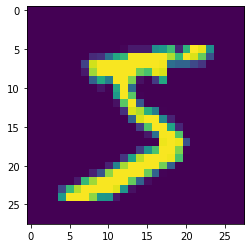

In [53]:
image = np.array(mnist.data[0]).reshape(28,28)
plt.imshow(image)

### Przycięcie obrazka

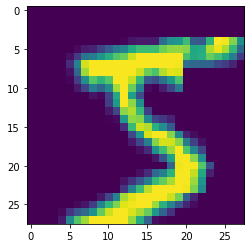

In [54]:
crop = iaa.Crop(px=(1, 5)) # przytnij od 1 do 5 pixeli z każdej strony
cropped = crop(images=[image])

plt.imshow(cropped[0])

### Rozmycie obrazka

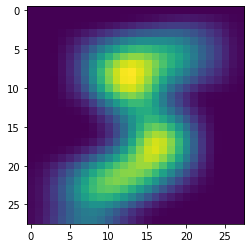

In [55]:
blur = iaa.GaussianBlur(sigma=(2.0, 3.0))
blurred = blur(images=[image])

plt.imshow(blurred[0])

### Obrót obrazka

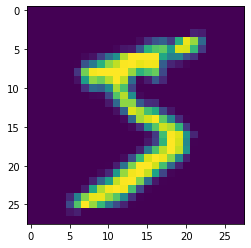

In [56]:
rotate = iaa.Affine(rotate=(-15, 15))
rotated = rotate(images=[image])

plt.imshow(rotated[0])

### Ciąg operacji na zbiorze

In [57]:
seq = iaa.Sequential([
    iaa.Sometimes(0.7, iaa.GaussianBlur(sigma=(2.0, 3.0))),
    iaa.Affine(rotate=(-15, 15))
])

#tutaj polecam zastosować lepsze wybieranie danych
images = [np.array(i).reshape(28,28) for i in mnist.data[:100]]
augmented_images = seq(images=images)

print(len(augmented_images))

100


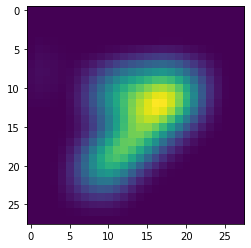

In [58]:
# Spróbuj wybrać losowy index z przedziało 0-100
plt.imshow(augmented_images[29])

## Zadanie

Przetestuj klasyfikator kNN na zbiorze MNIST/FMNIST rozszerzając zbiór przy pomocy imgaug oraz tworząc obrazki dodatkowe poprzez zaburzenie danych (np. dla x% pikseli losować liczbę 0,1 (MNIST), i odpowiednią – stopień szarości - dla zbioru FMNIST).
Porównaj paremetry jakości klasyfikatorów dla zmodyfikowanych danych.

# Parametry

In [59]:
# Zalecane wartości parametrów dla MNIST
train_size=0.008
test_size=0.002
K = 3
augmented_coeff=0.5
binary_threshold=70 #0-255

In [60]:
# Podziel zbiór na dane treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, train_size=train_size, test_size=test_size)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 560
Test set size: 140


In [61]:
# Przetestuj dokładność klasyfikatora bez operacji na danych treningowych
check_knn_accuracy(X_train, X_test, y_train, y_test)

def image_mnist(data):
    data = [i for i in data]
    img = np.zeros((28,28), dtype=float)
    for x in range(28):
        for y in range(28):
            img[y][x]=data[y*28+x]
    return img

0.8142857142857143

0.8285714285714286


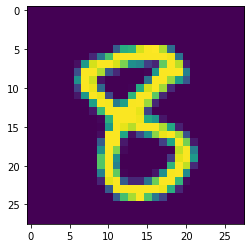

In [177]:
#Testowany obrazek X_train[8]
plt.imshow(image_mnist(X_train[8]))
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)
y_predicted = knn.predict(X_test)
print(accuracy_score(y_test, y_predicted))

0.7285714285714285


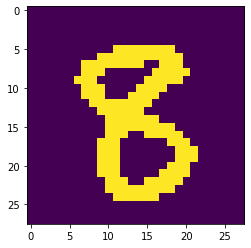

In [178]:
#2
binarized = [[1 if b > 70 else 0 for b in image] for image in X_train]

knn = KNeighborsClassifier(3)
knn.fit(binarized, y_train)
y_predicted = knn.predict(X_test)

plot_mnist(binarized[8])
print(accuracy_score(y_test, y_predicted))

0.85


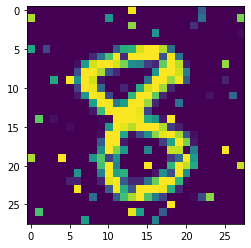

In [202]:
# Przetestuj dokładność klasyfikatora po dodaniu próbek zawierających szum
noise = iaa.ImpulseNoise(0.1)
noised = noise(images=[X_train])

plot_mnist(noised[0][8])

knn = KNeighborsClassifier(3)
knn.fit(noised[0], y_train)
y_predicted = knn.predict(X_test)
print(accuracy_score(y_test, y_predicted))

Nothing 0.8285714285714286
Blur 0.8428571428571429
Rotation + Blur 0.8571428571428571
Rotation + Blur + Crop 0.7642857142857142
Rotation + Blur + Crop + Noise 0.7857142857142857


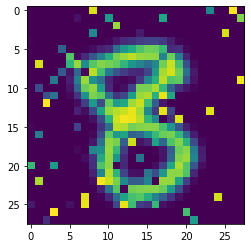

In [203]:
# Przetestuj dokładność klasyfikatora po dodaniu próbek poddanych kilku operacjom augmentacji
# (np. dodanie szumu, rozmycia, obrotu, przycięcia)
#plt.imshow(X_train)

def array_mnist(img):
    return [img[i][j] for i in range(28) for j in range(28)]

def printAccuracy(probe, img, train=y_train):
    knn = KNeighborsClassifier(3)
    knn.fit(img, train)
    y_predicted = knn.predict(X_test)
    print(probe, accuracy_score(y_test, y_predicted))
    
def printImageAccuracy(probe, img_train, train=y_train):
    img = [array_mnist(i) for i in img_train]
    knn = KNeighborsClassifier(3)
    knn.fit(img, train)
    y_predicted = knn.predict(X_test)
    print(probe, accuracy_score(y_test, y_predicted))
    
#plt.imshow(image_mnist(X_train[8]))

# No effect
test_images = [image_mnist(i) for i in X_train]
printImageAccuracy("Nothing", test_images, y_train)

#plt.imshow(test_images[8])

# Blur
blur = iaa.GaussianBlur((0.5, 0.7))
probe1 = blur(images=test_images)
printImageAccuracy("Blur", probe1)

# Rotation + Blur
rotate = iaa.Affine(rotate=(-10, 10))
probe2 = blur(images=test_images)
#plt.imshow(probe2[8])
printImageAccuracy("Rotation + Blur", probe2)

# Rotation + Blur + Crop
crop = iaa.Crop(px=(1, 2))
test_images = [image_mnist(i) for i in test_arrays]
probe3 = crop(images=test_images)
#plt.imshow(probe3[8])
printImageAccuracy("Rotation + Blur + Crop", probe3)

# Rotation + Blur + Crop + Noise
noise = iaa.ImpulseNoise(0.1)
probe4 = noise(images=test_images)
plt.imshow(probe4[8])
printImageAccuracy("Rotation + Blur + Crop + Noise", probe4)